In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
allstocks = pd.read_pickle("Data/allstock_reduced.pickle").pct_change().loc["2021"]
mask = pd.read_pickle("Data/spx_mask.pickle").loc["2021"].iloc[-1] # 마지막 날만 가져온다

In [60]:
# 2022년 마지막날의 S&P500 구성 종목을 가져오기 위해서 기업의 리스트를 뽑는다
col = mask.dropna().index
len(col)

505

In [61]:
# S&P500 구성종목만 가져온다
sp500 = allstocks.loc[:,col]

In [62]:
# corr_matrix 계산
cor_matrix = sp500.corr()
cor_matrix

PERMNO,14702,50876,60442,19502,59176,43350,64995,66181,66157,61735,...,21124,18312,75694,17700,15850,63467,13210,83597,15272,90090
PERMNO,,,,,,,,,,,,,,,,,,,,,
14702,1.000000,0.165000,0.280997,0.162490,0.300411,0.291537,0.283420,0.261844,0.195830,0.142459,...,0.030407,0.134597,0.442870,0.415111,0.387913,0.284719,0.415793,0.219690,0.467507,0.328525
50876,0.165000,1.000000,0.064066,0.122281,0.046084,0.098848,0.071675,0.120755,0.020745,0.061112,...,0.067345,0.125929,0.051943,-0.025061,0.037850,0.043163,0.134656,0.032264,0.010847,0.009041
60442,0.280997,0.064066,1.000000,0.272154,0.675121,0.490083,0.885863,0.256809,0.842928,0.297458,...,0.199744,-0.093065,0.125460,0.120301,0.137093,0.426860,0.036318,0.149605,0.195448,0.597891
19502,0.162490,0.122281,0.272154,1.000000,0.179491,0.302542,0.322490,0.205717,0.249713,0.152013,...,0.163626,0.036860,0.046487,-0.024076,0.076996,0.156988,0.033223,0.050988,0.058873,0.276490
59176,0.300411,0.046084,0.675121,0.179491,1.000000,0.499404,0.682297,0.204694,0.624066,0.297508,...,0.133705,-0.238091,0.232322,0.179941,0.227878,0.494461,0.171209,0.106780,0.152019,0.518884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63467,0.284719,0.043163,0.426860,0.156988,0.494461,0.474728,0.414634,0.391206,0.433441,0.548540,...,0.213932,-0.070337,0.326579,0.335784,0.205684,1.000000,0.290874,0.340079,0.123528,0.292884
13210,0.415793,0.134656,0.036318,0.033223,0.171209,0.314351,0.015173,0.233522,-0.028556,0.200541,...,0.072798,0.113867,0.436377,0.493090,0.297098,0.290874,1.000000,0.262136,0.322837,0.193227
83597,0.219690,0.032264,0.149605,0.050988,0.106780,0.236097,0.099527,0.262513,0.059396,0.195786,...,0.124380,0.029250,0.238983,0.316874,0.117980,0.340079,0.262136,1.000000,0.174656,-0.013786


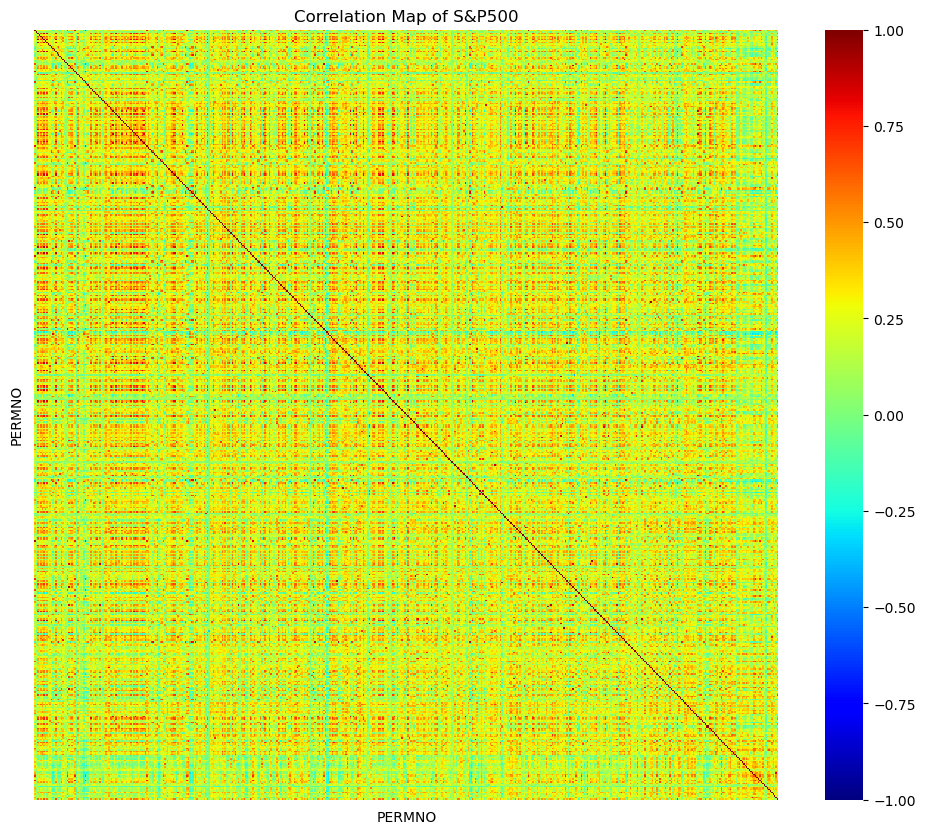

In [81]:
plt.figure(figsize=(12,10))
sns.heatmap(cor_matrix, 
            vmin=-1,
            vmax=1,
            cmap='jet', 
            xticklabels=False,
            yticklabels=False)

plt.title("Correlation Map of S&P500");

Clustering 해서 Corr Map도 뽑아보자

In [65]:
# Paper대로 T,N, 람다_+ 구현
t = len(sp500.index)
n = len(sp500.columns)
q = n/t 

lambda_plus = 1 + 2*(np.sqrt(q)) + q

In [66]:
# Cluster의 개수를 구하기(RMT 이론에 의해)
eigen_values = np.linalg.eigvalsh(cor_matrix)
k = (eigen_values > lambda_plus).sum()

In [67]:
# NaN 값 처리를 위해
mean = sp500.mean(1)
data = sp500.dropna(thresh=1).T.fillna(mean)

In [68]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=k, 
               n_init=200,
               max_iter=1000)
kmean.fit(data.values)
label = kmean.labels_ #라벨의 순서는 cov_matrix의 (idx,col)순서와 동일하다

In [69]:
# within corr 구하기
within_corr_dict = {}

for i in range(k): # i는 클러스터를 의미
    mask = (label == i)
    card_cluster = mask.sum()
    cluster_corr = sp500.loc[:,mask].corr().values
    
    with_in_cluster = (cluster_corr - np.diag(np.diag(cluster_corr))).sum() / (card_cluster * (card_cluster-1))
    if np.isnan(with_in_cluster) == True:
        with_in_cluster = 0
    within_corr_dict[i] = with_in_cluster 

C:\Users\user\AppData\Local\Temp\ipykernel_2960\3857817749.py:9: RuntimeWarning: invalid value encountered in double_scalars
  with_in_cluster = (cluster_corr - np.diag(np.diag(cluster_corr))).sum() / (card_cluster * (card_cluster-1))


In [70]:
within_corr_dict

{0: 0.7469425110136034,
 1: 0,
 2: 0.37246059768177914,
 3: 0.5961540952946428,
 4: 0.4734916314521051,
 5: 0.6397075860308208,
 6: 0.38133761088274865,
 7: 0.24979824837382292,
 8: 0.5874322038176735}

In [71]:
# between corr은 pair로 나와야함
between_corr_dict = {}

for i in range(k): # i는 클러스터를 의미
    mask_i = (label == i)
    card_i = mask_i.sum()
    stock_i = sp500.loc[:, mask_i]
    
    for j in range(k): # 클러스터 j를 뽑고
        if i == j:
            continue
        mask_j = (label == j)
        card_j = mask_j.sum()
        stock_j = sp500.loc[:, mask_j]
        
        all_corr = sp500.loc[:, mask_i+mask_j].corr().values
        all_corr_sum = (np.triu(all_corr) - np.diag(np.diag(all_corr))).sum()
        
        inner_corr_i = sp500.loc[:, mask_i].corr().values
        all_corr_sum_i = (np.triu(inner_corr_i) - np.diag(np.diag(inner_corr_i))).sum()        
        
        inner_corr_j = sp500.loc[:, mask_j].corr().values
        all_corr_sum_j = (np.triu(inner_corr_j) - np.diag(np.diag(inner_corr_j))).sum()   
        
        final_corr = all_corr_sum - all_corr_sum_i - all_corr_sum_j    
        
        between_cluster = final_corr / (2* card_i * card_j)
        between_corr_dict[(i,j)] = between_cluster

In [72]:
between_corr_dict

{(0, 1): -0.00635946581974,
 (0, 2): 0.03102833115839145,
 (0, 3): 0.08510192774943792,
 (0, 4): 0.07384878325918781,
 (0, 5): 0.21089298099154896,
 (0, 6): 0.16057069369644777,
 (0, 7): 0.03405665183396054,
 (0, 8): 0.2505785439367415,
 (1, 0): -0.00635946581974,
 (1, 2): 0.0010599860584285534,
 (1, 3): 0.008678680132231312,
 (1, 4): 0.005000709667707426,
 (1, 5): -0.0018315116641793967,
 (1, 6): -0.0006583939601529324,
 (1, 7): 0.004734663229407511,
 (1, 8): 0.005325927527994878,
 (2, 0): 0.03102833115839145,
 (2, 1): 0.0010599860584285534,
 (2, 3): -0.019890533380858354,
 (2, 4): 0.1755772659899069,
 (2, 5): 0.07689042354797919,
 (2, 6): 0.0895156984699167,
 (2, 7): 0.07531031630597015,
 (2, 8): 0.06657130245904314,
 (3, 0): 0.08510192774943796,
 (3, 1): 0.008678680132231312,
 (3, 2): -0.01989053338085836,
 (3, 4): -0.00897849210398475,
 (3, 5): 0.10181669437030356,
 (3, 6): 0.0778135586664437,
 (3, 7): 0.029757804267237176,
 (3, 8): 0.11048733549493317,
 (4, 0): 0.07384878325918778

In [73]:
# Within Correlation으로 S를 (i,j) 원소에 채우기... (i,j는 하나의 클러스터에 포함됨...)
cor_matrix_cluster = pd.DataFrame(index=cor_matrix.index,
                                  columns=cor_matrix.columns)

for i in range(k): # i는 각 클러스터를 의미함
    mask = (label == i)
    within_corr = within_corr_dict[i] # 이 within_corr을 각 회사의 pair 자리에 채워야함
    
    # select the rows and columns corresponding to the True values
    selected_rows = cor_matrix_cluster.loc[mask, :]
    selected_cols = cor_matrix_cluster.loc[:, mask]
    # fill in the selected values with a specific value 
    selected_rows.loc[:, selected_cols.columns] = within_corr
    selected_cols.loc[selected_rows.index, :] = within_corr
    # update the original correlation matrix with the modified values
    cor_matrix_cluster.loc[mask, :] = selected_rows
    cor_matrix_cluster.loc[:, mask] = selected_cols

np.fill_diagonal(cor_matrix_cluster.values, 1) # 대각 행렬에 1을 채운다

C:\Users\user\AppData\Local\Temp\ipykernel_2960\1806642392.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows.loc[:, selected_cols.columns] = within_corr
C:\Users\user\AppData\Local\Temp\ipykernel_2960\1806642392.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_cols.loc[selected_rows.index, :] = within_corr


In [75]:
# Between corr으로 각 위치에 값을 채우기: 각 클러스터 p,q에서 pair에서 주식을 뽑고
## 주식 i, j자리에 행렬을 between corr으로 채운다

for (p,q), between_corr in between_corr_dict.items(): # p,q는 클러스터를 의미함
    mask_p = (label == p)
    mask_q = (label == q)
    
    for i,bol_i in enumerate(mask_p): # i,j는 각각 클러스터에서 기업의 bol값을 의미함
        if bol_i:
            for j, bol_j in enumerate(mask_q):
                if bol_j:
                    cor_matrix_cluster.iloc[i,j] = between_corr

In [76]:
alpha = 0.5

r = alpha * cor_matrix_cluster + (1-alpha) * cor_matrix
r

PERMNO,14702,50876,60442,19502,59176,43350,64995,66181,66157,61735,...,21124,18312,75694,17700,15850,63467,13210,83597,15272,90090
PERMNO,,,,,,,,,,,,,,,,,,,,,
14702,1.0,0.099208,0.187771,0.122719,0.19168,0.187242,0.188982,0.14763,0.145187,0.087937,...,0.031911,0.304044,0.309224,0.295344,0.281745,0.183833,0.295685,0.126553,0.470499,0.211535
50876,0.099208,1.0,0.069698,0.115421,0.077323,0.103705,0.073502,0.185277,0.048037,0.155455,...,0.158572,0.079672,0.063627,0.025125,0.05658,0.075862,0.104983,0.141031,0.022131,0.042185
60442,0.187771,0.069698,1.0,0.24121,0.442693,0.350174,0.736647,0.166069,0.71518,0.186394,...,0.137537,0.00074,0.096016,0.093436,0.101832,0.318563,0.051444,0.112467,0.144996,0.592661
19502,0.122719,0.115421,0.24121,1.0,0.280415,0.34194,0.266378,0.157139,0.229989,0.130287,...,0.136094,0.059904,0.068002,0.03272,0.083256,0.269163,0.061369,0.079775,0.07091,0.243378
59176,0.19168,0.077323,0.442693,0.280415,1.0,0.440371,0.446281,0.156628,0.417165,0.203034,...,0.121133,-0.077572,0.160919,0.134729,0.158697,0.437899,0.130362,0.107671,0.117483,0.364574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63467,0.183833,0.075862,0.318563,0.269163,0.437899,0.428033,0.312449,0.249884,0.321853,0.328551,...,0.161247,0.006306,0.208047,0.21265,0.1476,1.0,0.190195,0.22432,0.103238,0.251575
13210,0.295685,0.104983,0.051444,0.061369,0.130362,0.201933,0.040872,0.154416,0.019008,0.137925,...,0.074054,0.144722,0.404419,0.432775,0.334779,0.190195,1.0,0.168723,0.249207,0.129899
83597,0.126553,0.141031,0.112467,0.079775,0.107671,0.172329,0.087428,0.256155,0.067363,0.222792,...,0.187089,0.031333,0.157147,0.196092,0.096645,0.22432,0.168723,1.0,0.104036,0.030772


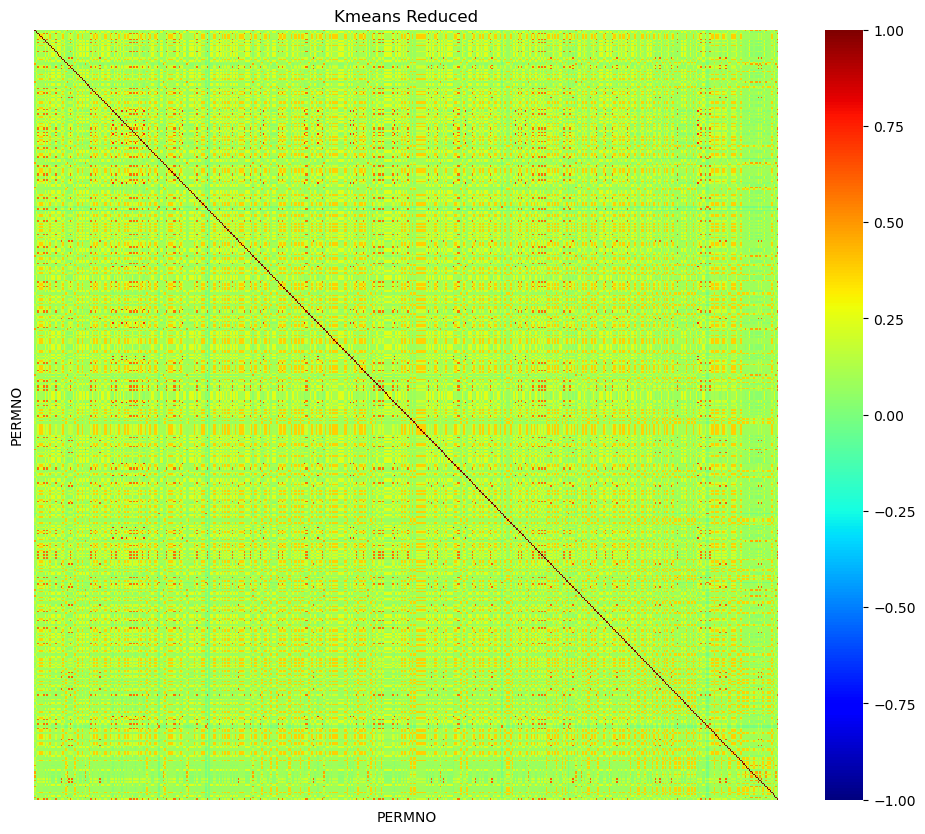

In [82]:
plt.figure(figsize=(12,10))
sns.heatmap(cor_matrix_cluster.astype("float64"), 
            vmin=-1,
            vmax=1,
            cmap='jet', 
            xticklabels=False,
            yticklabels=False)

plt.title("Kmeans Reduced");